In [ ]:
# Preprocessed Data
!gdown --id "1Lz1IHzyhCoWTsDuaD9Kf7OyoLK4XdFTr"
# Glove Vectors
!gdown --id "1Z6bjXmyCaoEzXYo_tRDwLTsfeA2F3K3j"
# train_data.csv
!gdown --id "1T48h84GLW3dpy9F6ble5nF_1gQxBO8rx"
# test_data.csv
!gdown --id "1sh4p_gNyiD_tMVdMTd6F8fkJS7ysJFXK"

Downloading...
From: https://drive.google.com/uc?id=1Lz1IHzyhCoWTsDuaD9Kf7OyoLK4XdFTr
To: /content/preprocessed_data.csv
124MB [00:00, 144MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Z6bjXmyCaoEzXYo_tRDwLTsfeA2F3K3j
To: /content/glove_vectors
128MB [00:02, 46.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1T48h84GLW3dpy9F6ble5nF_1gQxBO8rx
To: /content/train_data.csv
201MB [00:01, 137MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sh4p_gNyiD_tMVdMTd6F8fkJS7ysJFXK
To: /content/test_data.csv
133MB [00:01, 125MB/s] 


In [ ]:
!pip install tensorflow-gpu

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import re
import os
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re


from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

import tensorflow as tf
import tensorflow.keras as keras 
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split

# from tensorflow.keras import utils
from keras.utils import np_utils
from keras import metrics

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, Concatenate, Conv1D, MaxPooling1D, Dropout, LSTM
from tensorflow.keras.models import Sequential

from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import Normalizer


import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
tf.keras.backend.clear_session()

# Load Dataset

In [ ]:
data = pd.read_csv("/content/preprocessed_data.csv")
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

In [ ]:
data.head(3)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00


In [ ]:
data.shape

(109248, 9)

In [ ]:
y = data["project_is_approved"]
X = data.drop("project_is_approved", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
y_train = to_categorical(y_train,2)
y_test = to_categorical(y_test,2)

In [ ]:
print(y_test.sum())
print(len(y_test)-y_test.sum())
print(y_train.sum())
print(len(y_train)-y_train.sum())

21850.0
0.0
87398.0
0.0


In [ ]:
X_train.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
38113,ca,mr,grades_9_12,4,math_science music_arts,appliedsciences visualarts,john dewey said education not preparation life...,184.93


In [ ]:
y_test[0]

array([0., 1.], dtype=float32)

# Model 1

## Create Embedding Matrix for LSTM Input

In [ ]:
y = data["project_is_approved"]
X = data.drop("project_is_approved", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
y_train = to_categorical(y_train,2)
y_test = to_categorical(y_test,2)

In [ ]:
#use tf.tokenizer : remove '_' from filters as we need words joined by _ (new_york)
tokenizer = Tokenizer(lower=True, split=' ',filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}_~\t\n')
tokenizer.fit_on_texts(X_train["essay"])

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train["essay"])
test_sequences = tokenizer.texts_to_sequences(X_test["essay"])


In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print("Learned Vocab has size : ",vocab_size)
maxlen = max([len(x) for x in train_sequences])
print("Maximum len of words in train_data is: ", maxlen)

Learned Vocab has size :  50268
Maximum len of words in train_data is:  339


In [ ]:
# Pad the sequences based on maxLen
train_padded = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=maxlen)
test_padded = pad_sequences(test_sequences, padding='post', truncating='post', maxlen=maxlen)

In [ ]:
with open('glove_vectors', 'rb') as f:
  glove_vector = pickle.load(f)
  glove_words = set(glove_vector.keys())

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
	embedding_vector = glove_vector.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
print("Shape of Embedding Matrix: %d x %d"%(len(embedding_matrix),len(embedding_matrix[0])))

Shape of Embedding Matrix: 50268 x 300


## Tokenizing other inputs

### Input_school_state

In [ ]:
#use tf.tokenizer : remove '_' from filters as we need words joined by _ (new_york)
tokenizer = Tokenizer(lower=True, split=' ',filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}_~\t\n')
tokenizer.fit_on_texts(X_train["school_state"])

# Encode training data sentences into sequences
train_sequences_school_state = tokenizer.texts_to_sequences(X_train["school_state"])
test_sequences_school_state = tokenizer.texts_to_sequences(X_test["school_state"])

# all other data is of np.ndarray form, this is a list
train_sequences_school_state = np.array(train_sequences_school_state)
test_sequences_school_state = np.array(test_sequences_school_state)

vocab_size_school_state = len(tokenizer.word_index) + 1
maxlen_school_state = max([len(x) for x in train_sequences_school_state])

### project_grade_category

In [ ]:
#use tf.tokenizer : remove '-' from filters as we need words 5-6
tokenizer = Tokenizer(lower=True, split=' ',filters='!"#$%&()*+,./:;<=>?@[\\]^`{|}_~\t\n')
tokenizer.fit_on_texts(X_train["project_grade_category"])

# Encode training data sentences into sequences
train_sequences_grade = tokenizer.texts_to_sequences(X_train["project_grade_category"])
test_sequences_grade = tokenizer.texts_to_sequences(X_test["project_grade_category"])

# all other data is of np.ndarray form, this is a list
train_sequences_grade = np.array(train_sequences_grade)
test_sequences_grade = np.array(test_sequences_grade)

vocab_size_grade = len(tokenizer.word_index) + 1
maxlen_grade = max([len(x) for x in train_sequences_grade])

len(train_sequences_grade)

81936

### clean_categories

In [ ]:
#use tf.tokenizer : remove '-' from filters as we need words 5-6
tokenizer = Tokenizer(lower=True, split=' ',filters='!"#$%&()*+,./:;<=>?@[\\]^`{|}_~\t\n')
tokenizer.fit_on_texts(X_train["clean_categories"])

# Encode training data sentences into sequences
train_sequences_clean_cats = tokenizer.texts_to_sequences(X_train["clean_categories"])
test_sequences_clean_cats = tokenizer.texts_to_sequences(X_test["clean_categories"])

vocab_size_clean_cats = len(tokenizer.word_index) + 1
maxlen_clean_cats = max([len(x) for x in train_sequences_clean_cats])
print(len(train_sequences_clean_cats))

# Pad the sequences based on maxLen
train_sequences_clean_cats = pad_sequences(train_sequences_clean_cats, padding='post', truncating='post', maxlen=maxlen_clean_cats)
test_sequences_clean_cats = pad_sequences(test_sequences_clean_cats, padding='post', truncating='post', maxlen=maxlen_clean_cats)



81936


### clean_subcategories

In [ ]:
#use tf.tokenizer : remove '-' from filters as we need words 5-6
tokenizer = Tokenizer(lower=True, split=' ',filters='!"#$%&()*+,./:;<=>?@[\\]^`{|}_~\t\n')
tokenizer.fit_on_texts(X_train["clean_subcategories"])

# Encode training data sentences into sequences
train_sequences_clean_subcats = tokenizer.texts_to_sequences(X_train["clean_subcategories"])
test_sequences_clean_subcats = tokenizer.texts_to_sequences(X_test["clean_subcategories"])

vocab_size_clean_subcats = len(tokenizer.word_index) + 1
maxlen_clean_subcats = max([len(x) for x in train_sequences_clean_subcats])

# Pad the sequences based on maxLen
train_sequences_clean_subcats = pad_sequences(train_sequences_clean_subcats, padding='post', truncating='post', maxlen=maxlen_clean_subcats)
test_sequences_clean_subcats = pad_sequences(test_sequences_clean_subcats, padding='post', truncating='post', maxlen=maxlen_clean_subcats)


### teacher_prefix

In [ ]:
#use tf.tokenizer : remove '-' from filters as we need words 5-6
tokenizer = Tokenizer(lower=True, split=' ',filters='!"#$%&()*+,./:;<=>?@[\\]^`{|}_~\t\n')
tokenizer.fit_on_texts(X_train["teacher_prefix"])

# Encode training data sentences into sequences
train_sequences_teacher_prefix = tokenizer.texts_to_sequences(X_train["teacher_prefix"])
test_sequences_teacher_prefix = tokenizer.texts_to_sequences(X_test["teacher_prefix"])

vocab_size_teacher_prefix = len(tokenizer.word_index) + 1
maxlen_teacher_prefix = max([len(x) for x in train_sequences_teacher_prefix])

# Pad the sequences based on maxLen
train_sequences_teacher_prefix = pad_sequences(train_sequences_teacher_prefix, padding='post', truncating='post', maxlen=maxlen_teacher_prefix)
test_sequences_teacher_prefix = pad_sequences(test_sequences_teacher_prefix, padding='post', truncating='post', maxlen=maxlen_teacher_prefix)


### Numerical Features

In [ ]:
# price teacher_number_of_previously_posted_projects
train_numerical = X_train[["teacher_number_of_previously_posted_projects","price"]].values
test_numerical = X_test[["teacher_number_of_previously_posted_projects","price"]].values
print(train_numerical[0:2])

[[  1.   184.87]
 [ 32.   157.97]]


In [ ]:
maxlen_clean_subcats

5

## Model Building

In [ ]:
Input_text = Input(shape=(maxlen,)) 
embed_1 = Embedding(vocab_size,300,input_length=maxlen, weights=[embedding_matrix], trainable=False)(Input_text)
lstm_1 = LSTM(units=128)(embed_1)
flatten_1 = Flatten()(lstm_1) 

Input_school_state = Input(shape=(maxlen_school_state,))
embed_2 = Embedding(vocab_size_school_state,100,input_length=maxlen_school_state)(Input_school_state)
flatten_2 = Flatten()(embed_2) 

Input_grade = Input(shape=(maxlen_grade,))
embed_3 = Embedding(vocab_size_grade,100,input_length=maxlen_grade)(Input_grade)
flatten_3 = Flatten()(embed_3) 

Input_clean_cats = Input(shape=(maxlen_clean_cats,))
embed_4 = Embedding(vocab_size_clean_cats,100,input_length=maxlen_clean_cats)(Input_clean_cats)
flatten_4 = Flatten()(embed_4)

Input_clean_subcats = Input(shape=(maxlen_clean_subcats,))
embed_5 = Embedding(vocab_size_clean_subcats,100,input_length=maxlen_clean_subcats)(Input_clean_subcats)
flatten_5 = Flatten()(embed_5)

Input_teacher_prefix = Input(shape=(maxlen_teacher_prefix,))
embed_6 = Embedding(vocab_size_teacher_prefix,100,input_length=maxlen_teacher_prefix)(Input_teacher_prefix)
flatten_6 = Flatten()(embed_6)

Input_numerical = Input(shape=(2,))
dense_numerical = dense_2 = Dense(300,activation='relu')(Input_numerical)

concat = Concatenate()([flatten_1, flatten_2, flatten_3, flatten_4, flatten_5, flatten_6, dense_numerical])

dense_1 = Dense(300,activation='relu')(concat)
drop_1 = Dropout(0.3)(dense_1)
dense_2 = Dense(150,activation='relu')(drop_1)
# drop_2 = Dropout(0.4)(dense_2)
dense_2 = Dense(150,activation='relu')(dense_2)
drop_3 = Dropout(0.4)(dense_2)
dense_3 = Dense(64,activation='relu')(drop_3)
output = Dense(2, activation='softmax')(dense_3)


In [ ]:
model = keras.Model([Input_text, Input_school_state, Input_grade, Input_clean_cats,Input_clean_subcats,Input_teacher_prefix, Input_numerical],output)

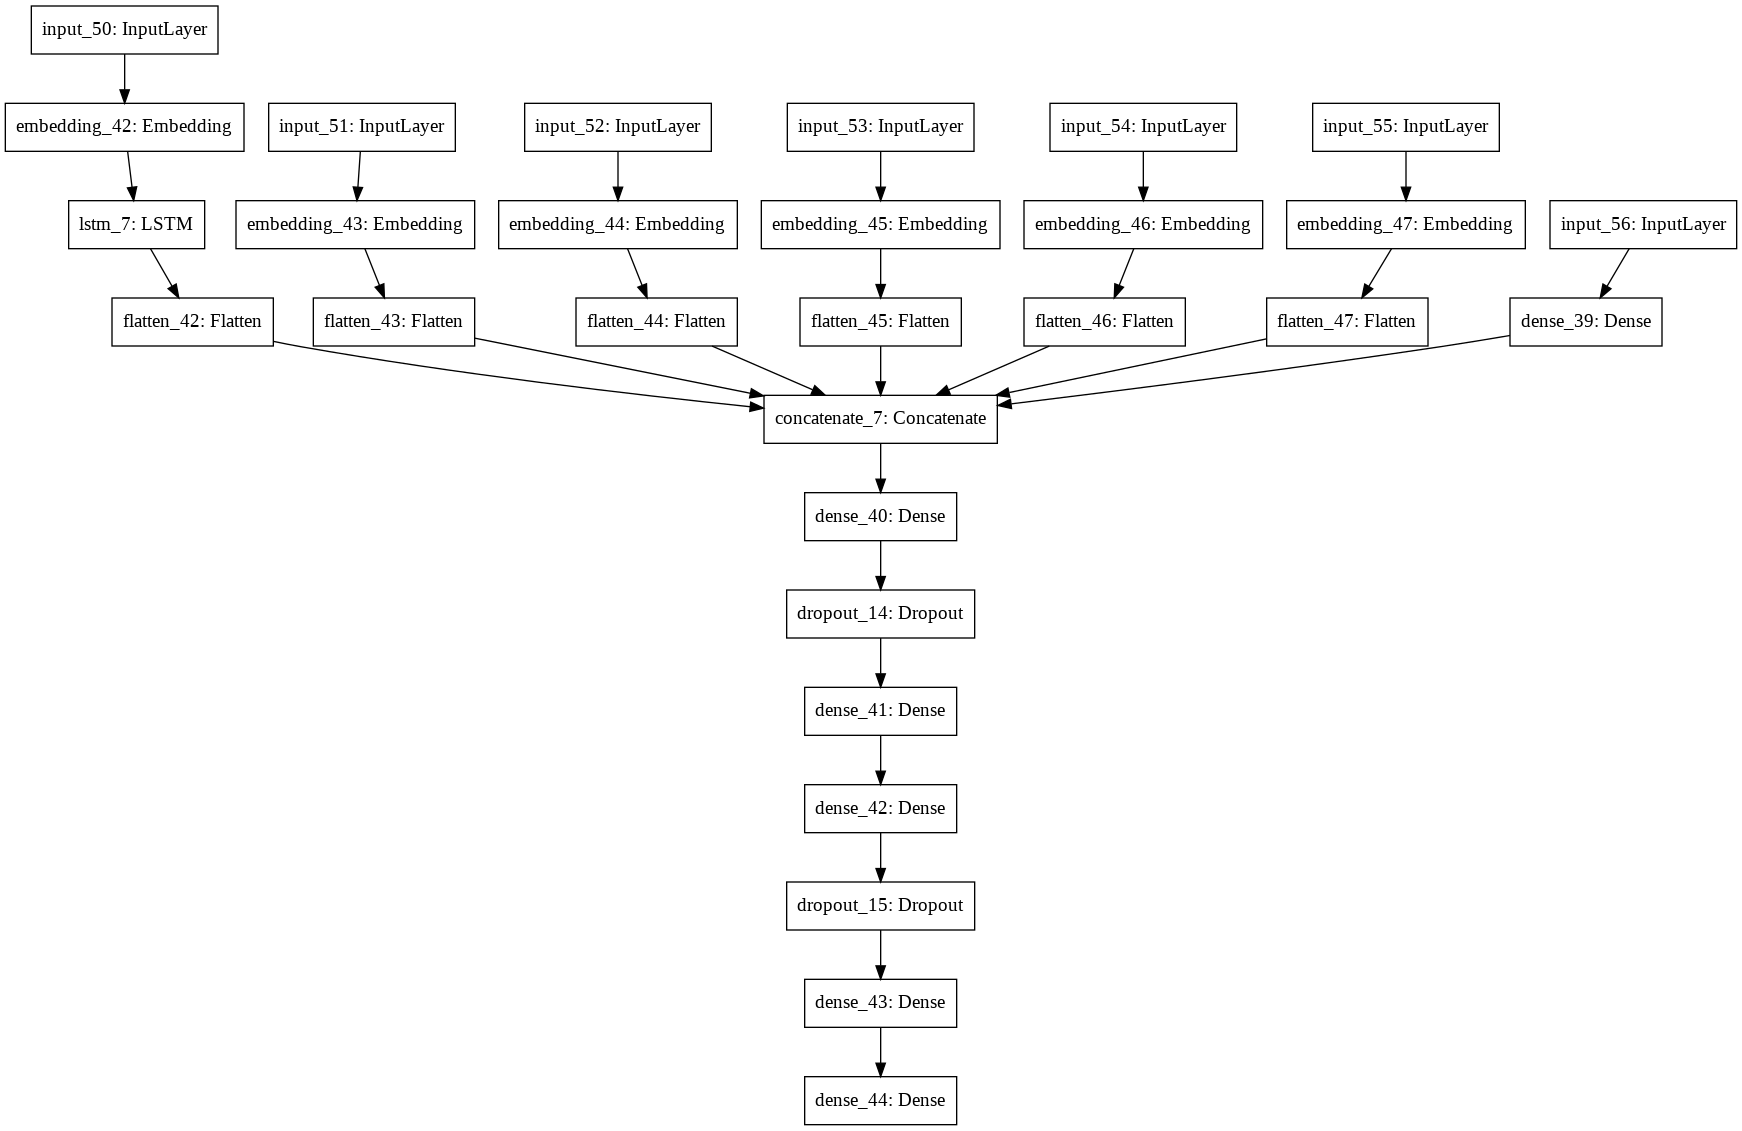

In [ ]:
plot_model(model)

In [ ]:
class Metrics_Callback(tf.keras.callbacks.Callback):
  def __init__(self,x_val,y_val):
    self.x_val = x_val
    self.y_val = y_val


  def on_train_begin(self, logs={}):
    self.history = {"test_auc":[], "train_auc":[]}

  def on_epoch_end(self, epoch, logs={}):
    # self.model.predict_classes
    y_pred_test = self.model.predict(self.x_val)[:,1]
    y_true_test = [np.argmax(x) for x in self.y_val]
    auc_score_test = roc_auc_score(y_true_test,y_pred_test, average='samples')
    print("Test AUC_Score: ", auc_score_test)
    self.history["test_auc"].append(auc_score_test)



In [ ]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

train_data_inputs = [train_padded, train_sequences_school_state, train_sequences_grade, train_sequences_clean_cats, train_sequences_clean_subcats, train_sequences_teacher_prefix, train_numerical]
test_data_inputs = [test_padded, test_sequences_school_state, test_sequences_grade, test_sequences_clean_cats, test_sequences_clean_subcats, test_sequences_teacher_prefix, test_numerical]


In [ ]:
len(train_data_inputs[0])/1000

81.936

In [ ]:
Metrics = Metrics_Callback(test_data_inputs,y_test)
model.fit(train_data_inputs,y_train,batch_size=32,
  epochs=20,
  callbacks=  [Metrics],
  validation_data=(test_data_inputs,y_test)
)

2561/2561 [==============================] - 75s 29ms/step - loss: 0.4177 - accuracy: 0.8476 - val_loss: 0.4157 - val_accuracy: 0.8486
Test AUC_Score:  0.6111876316141757
Epoch 5/20
2561/2561 [==============================] - 75s 29ms/step - loss: 0.4124 - accuracy: 0.8496 - val_loss: 0.4178 - val_accuracy: 0.8486
Test AUC_Score:  0.6138885337262786
Epoch 6/20
2561/2561 [==============================] - 75s 29ms/step - loss: 0.4176 - accuracy: 0.8468 - val_loss: 0.4147 - val_accuracy: 0.8486
Test AUC_Score:  0.6130948478767136
Epoch 7/20
2561/2561 [==============================] - 74s 29ms/step - loss: 0.4107 - accuracy: 0.8506 - val_loss: 0.4173 - val_accuracy: 0.8486
Test AUC_Score:  0.6115215545962641
Epoch 8/20
2561/2561 [==============================] - 74s 29ms/step - loss: 0.4147 - accuracy: 0.8479 - val_loss: 0.4155 - val_accuracy: 0.8486
Test AUC_Score:  0.6154091333477772
Epoch 9/20
2561/2561 [==============================] - 74s 29ms/step - loss: 0.4128 - accuracy: 0.84

In [ ]:
print(model.)

In [ ]:
Metrics.history

{'test_auc': [0.6058482800387054,
  0.6228691465849348,
  0.6216811072604137,
  0.6212860923760103,
  0.6232798704507279,
  0.6277788684618799,
  0.6256974675567275,
  0.6273006392788497,
  0.6258499610197097,
  0.6292176775969214,
  0.6247646222261269,
  0.6303457661060492,
  0.6276978766893481,
  0.6265316035124051,
  0.6274719563900729,
  0.6284506608858729,
  0.622856687917529,
  0.629640834044133,
  0.6261775018900602,
  0.6227937528652197],
 'train_auc': []}

# Model 2

## Remove words based in IDF Score in essay

In [ ]:
y = data["project_is_approved"]
X = data.drop("project_is_approved", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
y_train = to_categorical(y_train,2)
y_test = to_categorical(y_test,2)

In [ ]:
tfidf = TfidfVectorizer(analyzer='word',stop_words= 'english')

tfidf.fit(X_train["essay"].values)
x_train_fit = tfidf.transform(X_train["essay"])

tfidf_scores = zip( tfidf.idf_, tfidf.get_feature_names())

# sort words in increasing order of tfidf values
tfidf_scores = sorted(tfidf_scores, key = lambda x:x[0])
word_list = [x[1] for x in tfidf_scores]
idf_scores_list =  [x[0] for x in tfidf_scores]


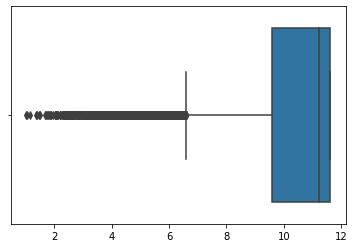

In [ ]:
sns.boxplot([x[0] for x in tfidf_scores])

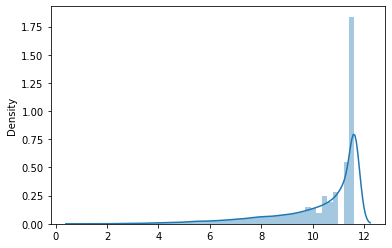

In [ ]:
sns.distplot(idf_scores_list)

In [ ]:
percent_25=  np.percentile([x[0] for x in tfidf_scores],25)
percent_50=  np.percentile([x[0] for x in tfidf_scores],50)
percent_75=  np.percentile([x[0] for x in tfidf_scores],75)
print("25th Percentile : ",percent_25)
print("50th Percentile : ",percent_50)
print("75th Percentile : ",percent_75)
print("IQR : ", percent_75-percent_25)

print("So, we can ignore words with IDF < %.3f & IDF > %.3f which would eliminate frequent and rare words which wont add much knowledge"%(percent_25,percent_75))

25th Percentile :  9.605655737173175
50th Percentile :  11.215093649607276
75th Percentile :  11.62055875771544
IQR :  2.014903020542265
So, we can ignore words with IDF < 9.606 & IDF > 11.621 which would eliminate frequent and rare words which wont add much knowledge


In [ ]:
#removing low and high IDF values
tfidf_removed_words = set([word for idf_vals, word in tfidf_scores if idf_vals<percent_25 and idf_vals>percent_75])

def remove_words(data_values, word_to_be_removed):
  re_remove_words = re.compile("("+ "|".join(word_to_be_removed) + ")")
  clean_data = data_values
  for idx, row in tqdm(enumerate(clean_data)):
    row = re.sub(re_remove_words, "",row) #remove words
    row = re.sub(" +"," ",row) # replace multiple spaces by one space
    clean_data[idx] = row
  
  return clean_data
  

In [ ]:
X_train_cleaned_text = remove_words(X_train["essay"].values, tfidf_removed_words)
X_test_cleaned_text = remove_words(X_test["essay"].values, tfidf_removed_words)

81936it [00:12, 6804.07it/s]
27312it [00:04, 6619.21it/s]


In [ ]:
#use tf.tokenizer : remove '_' from filters as we need words joined by _ (new_york)
tokenizer = Tokenizer(lower=True, split=' ',filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}_~\t\n')
tokenizer.fit_on_texts(X_train_cleaned_text)

# Encode training data sentences into sequences
train_sequences_seq_text = tokenizer.texts_to_sequences(X_train_cleaned_text)
test_sequences_seq_text  = tokenizer.texts_to_sequences(X_test_cleaned_text)

vocab_size_seq_text = len(tokenizer.word_index) + 1
maxlen_seq_text  = max([len(x) for x in train_sequences_seq_text])

# Pad the sequences based on maxLen
train_sequences_seq_text = pad_sequences(train_sequences_seq_text, padding='post', truncating='post', maxlen=maxlen_seq_text)
test_sequences_seq_text = pad_sequences(test_sequences_seq_text, padding='post', truncating='post', maxlen=maxlen_seq_text)



## Tokenizing other inputs

### Input_school_state

In [ ]:
#use tf.tokenizer : remove '_' from filters as we need words joined by _ (new_york)
tokenizer = Tokenizer(lower=True, split=' ',filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}_~\t\n')
tokenizer.fit_on_texts(X_train["school_state"])

# Encode training data sentences into sequences
train_sequences_school_state = tokenizer.texts_to_sequences(X_train["school_state"])
test_sequences_school_state = tokenizer.texts_to_sequences(X_test["school_state"])

# all other data is of np.ndarray form, this is a list
train_sequences_school_state = np.array(train_sequences_school_state)
test_sequences_school_state = np.array(test_sequences_school_state)

# Pad the sequences based on maxLen
# train_sequences_clean_cats = pad_sequences(train_sequences_clean_cats, padding='post', truncating='post', maxlen=maxlen_clean_cats)
# test_sequences_clean_cats = pad_sequences(test_sequences_clean_cats, padding='post', truncating='post', maxlen=maxlen_clean_cats)

vocab_size_school_state = len(tokenizer.word_index) + 1
maxlen_school_state = max([len(x) for x in train_sequences_school_state])

### project_grade_category

In [ ]:
#use tf.tokenizer : remove '-' from filters as we need words 5-6
tokenizer = Tokenizer(lower=True, split=' ',filters='!"#$%&()*+,./:;<=>?@[\\]^`{|}_~\t\n')
tokenizer.fit_on_texts(X_train["project_grade_category"])

# Encode training data sentences into sequences
train_sequences_grade = tokenizer.texts_to_sequences(X_train["project_grade_category"])
test_sequences_grade = tokenizer.texts_to_sequences(X_test["project_grade_category"])

# all other data is of np.ndarray form, this is a list
train_sequences_grade = np.array(train_sequences_grade)
test_sequences_grade = np.array(test_sequences_grade)

vocab_size_grade = len(tokenizer.word_index) + 1
maxlen_grade = max([len(x) for x in train_sequences_grade])

len(train_sequences_grade)

81936

### clean_categories

In [ ]:
#use tf.tokenizer : remove '-' from filters as we need words 5-6
tokenizer = Tokenizer(lower=True, split=' ',filters='!"#$%&()*+,./:;<=>?@[\\]^`{|}_~\t\n')
tokenizer.fit_on_texts(X_train["clean_categories"])

# Encode training data sentences into sequences
train_sequences_clean_cats = tokenizer.texts_to_sequences(X_train["clean_categories"])
test_sequences_clean_cats = tokenizer.texts_to_sequences(X_test["clean_categories"])

vocab_size_clean_cats = len(tokenizer.word_index) + 1
maxlen_clean_cats = max([len(x) for x in train_sequences_clean_cats])
print(len(train_sequences_clean_cats))

# Pad the sequences based on maxLen
train_sequences_clean_cats = pad_sequences(train_sequences_clean_cats, padding='post', truncating='post', maxlen=maxlen_clean_cats)
test_sequences_clean_cats = pad_sequences(test_sequences_clean_cats, padding='post', truncating='post', maxlen=maxlen_clean_cats)



81936


### clean_subcategories

In [ ]:
#use tf.tokenizer : remove '-' from filters as we need words 5-6
tokenizer = Tokenizer(lower=True, split=' ',filters='!"#$%&()*+,./:;<=>?@[\\]^`{|}_~\t\n')
tokenizer.fit_on_texts(X_train["clean_subcategories"])

# Encode training data sentences into sequences
train_sequences_clean_subcats = tokenizer.texts_to_sequences(X_train["clean_subcategories"])
test_sequences_clean_subcats = tokenizer.texts_to_sequences(X_test["clean_subcategories"])

vocab_size_clean_subcats = len(tokenizer.word_index) + 1
maxlen_clean_subcats = max([len(x) for x in train_sequences_clean_subcats])

# Pad the sequences based on maxLen
train_sequences_clean_subcats = pad_sequences(train_sequences_clean_subcats, padding='post', truncating='post', maxlen=maxlen_clean_subcats)
test_sequences_clean_subcats = pad_sequences(test_sequences_clean_subcats, padding='post', truncating='post', maxlen=maxlen_clean_subcats)


### teacher_prefix

In [ ]:
#use tf.tokenizer : remove '-' from filters as we need words 5-6
tokenizer = Tokenizer(lower=True, split=' ',filters='!"#$%&()*+,./:;<=>?@[\\]^`{|}_~\t\n')
tokenizer.fit_on_texts(X_train["teacher_prefix"])

# Encode training data sentences into sequences
train_sequences_teacher_prefix = tokenizer.texts_to_sequences(X_train["teacher_prefix"])
test_sequences_teacher_prefix = tokenizer.texts_to_sequences(X_test["teacher_prefix"])

vocab_size_teacher_prefix = len(tokenizer.word_index) + 1
maxlen_teacher_prefix = max([len(x) for x in train_sequences_teacher_prefix])

# Pad the sequences based on maxLen
train_sequences_teacher_prefix = pad_sequences(train_sequences_teacher_prefix, padding='post', truncating='post', maxlen=maxlen_teacher_prefix)
test_sequences_teacher_prefix = pad_sequences(test_sequences_teacher_prefix, padding='post', truncating='post', maxlen=maxlen_teacher_prefix)


### Numerical Features

In [ ]:
# price teacher_number_of_previously_posted_projects

train_numerical = X_train[["teacher_number_of_previously_posted_projects","price"]].values
test_numerical = X_test[["teacher_number_of_previously_posted_projects","price"]].values

# train_numerical = [[x,y] for x,y in zip(X_train_price_norm, X_train_prev_proj_norm)]
# test_numerical =[[x,y] for x,y in zip(X_test_price_norm, X_test_prev_proj_norm)]
print(train_numerical[0])


[ 1.   93.32]


## Model Building

In [ ]:
Input_text = Input(shape=(maxlen_seq_text,)) 
embed_1 = Embedding(vocab_size_seq_text,300,input_length=maxlen_seq_text)(Input_text)
lstm_1 = LSTM(units=128)(embed_1)
flatten_1 = Flatten()(lstm_1) 

Input_school_state = Input(shape=(maxlen_school_state,))
embed_2 = Embedding(vocab_size_school_state,10,input_length=maxlen_school_state)(Input_school_state)
flatten_2 = Flatten()(embed_2) 

Input_grade = Input(shape=(maxlen_grade,))
embed_3 = Embedding(vocab_size_grade,10,input_length=maxlen_grade)(Input_grade)
flatten_3 = Flatten()(embed_3) 

Input_clean_cats = Input(shape=(maxlen_clean_cats,))
embed_4 = Embedding(vocab_size_clean_cats,10,input_length=maxlen_clean_cats)(Input_clean_cats)
flatten_4 = Flatten()(embed_4)

Input_clean_subcats = Input(shape=(maxlen_clean_subcats,))
embed_5 = Embedding(vocab_size_clean_subcats,10,input_length=maxlen_clean_subcats)(Input_clean_subcats)
flatten_5 = Flatten()(embed_5)

Input_teacher_prefix = Input(shape=(maxlen_teacher_prefix,))
embed_6 = Embedding(vocab_size_teacher_prefix,10,input_length=maxlen_teacher_prefix)(Input_teacher_prefix)
flatten_6 = Flatten()(embed_6)

Input_numerical = Input(shape=(2,))
dense_numerical = dense_2 = Dense(10,activation='relu')(Input_numerical)

concat = Concatenate()([flatten_1, flatten_2, flatten_3, flatten_4, flatten_5, flatten_6, dense_numerical])

dense_1 = Dense(128,activation='relu')(concat)
drop_1 = Dropout(0.4)(dense_1)
dense_2 = Dense(64,activation='relu')(drop_1)
drop_2 = Dropout(0.4)(dense_2)
dense_2 = Dense(48,activation='relu')(drop_2)

output = Dense(2, activation='softmax')(dense_2)


In [ ]:
model2 = keras.Model([Input_text, Input_school_state, Input_grade, Input_clean_cats,Input_clean_subcats,Input_teacher_prefix, Input_numerical],output)

In [ ]:
# plot_model(model2)

In [ ]:
model2.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

train_data_inputs = [train_sequences_seq_text, train_sequences_school_state, train_sequences_grade, train_sequences_clean_cats, train_sequences_clean_subcats, train_sequences_teacher_prefix, train_numerical]
test_data_inputs = [test_sequences_seq_text, test_sequences_school_state, test_sequences_grade, test_sequences_clean_cats, test_sequences_clean_subcats, test_sequences_teacher_prefix, test_numerical]


In [ ]:
class Metrics_Callback(tf.keras.callbacks.Callback):
  def __init__(self,x_val,y_val):
    self.x_val = x_val
    self.y_val = y_val

  def on_train_begin(self, logs={}):
    self.history = {"auc":[]}

  def on_epoch_end(self, epoch, logs={}):
    # self.model.predict_classes
    y_pred = self.model.predict(self.x_val)[:,1]
    y_true = [np.argmax(x) for x in self.y_val]

    auc_score = roc_auc_score(y_true,y_pred)
    print("AUC : ",auc_score)
    self.history["auc"].append(auc_score)


In [ ]:
Metrics = Metrics_Callback(test_data_inputs,y_test)
model2.fit(train_data_inputs,y_train,
  epochs=20,
  callbacks=  [Metrics],
  validation_data=(test_data_inputs,y_test)
)

Epoch 1/20
2561/2561 [==============================] - 242s 94ms/step - loss: 0.4154 - accuracy: 0.8485 - val_loss: 0.4159 - val_accuracy: 0.8486
AUC :  0.6145381126944501
Epoch 2/20
2561/2561 [==============================] - 240s 94ms/step - loss: 0.4151 - accuracy: 0.8486 - val_loss: 0.4149 - val_accuracy: 0.8486
AUC :  0.6150307425927175
Epoch 3/20
2561/2561 [==============================] - 241s 94ms/step - loss: 0.4140 - accuracy: 0.8486 - val_loss: 0.4151 - val_accuracy: 0.8486
AUC :  0.6165289179378521
Epoch 4/20
2561/2561 [==============================] - 241s 94ms/step - loss: 0.4138 - accuracy: 0.8486 - val_loss: 0.4152 - val_accuracy: 0.8486
AUC :  0.6153202290988009
Epoch 5/20
2561/2561 [==============================] - 241s 94ms/step - loss: 0.4131 - accuracy: 0.8486 - val_loss: 0.4161 - val_accuracy: 0.8486
AUC :  0.6149497095307692
Epoch 6/20
2561/2561 [==============================] - 241s 94ms/step - loss: 0.4132 - accuracy: 0.8486 - val_loss: 0.4151 - val_accur

In [ ]:
Metrics.history

{'auc': [0.6190942781050095,
  0.6149607521437169,
  0.6192560208269209,
  0.621121591259617,
  0.6225512053838793,
  0.6233358881394679,
  0.6228199263528134,
  0.6226090891230774,
  0.6230958612724828,
  0.6221943730224491]}

# Model 3

In [ ]:
y = data["project_is_approved"]
X = data.drop("project_is_approved", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
y_train = to_categorical(y_train,2)
y_test = to_categorical(y_test,2)

## Create Embedding Matrix for LSTM Input

In [ ]:
y = data["project_is_approved"]
X = data.drop("project_is_approved", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
y_train = to_categorical(y_train,2)
y_test = to_categorical(y_test,2)

In [ ]:
#use tf.tokenizer : remove '_' from filters as we need words joined by _ (new_york)
tokenizer = Tokenizer(lower=True, split=' ',filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}_~\t\n')
tokenizer.fit_on_texts(X_train["essay"])

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train["essay"])
test_sequences = tokenizer.texts_to_sequences(X_test["essay"])


In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print("Learned Vocab has size : ",vocab_size)
maxlen = max([len(x) for x in train_sequences])
print("Maximum len of words in train_data is: ", maxlen)

Learned Vocab has size :  50473
Maximum len of words in train_data is:  339


In [ ]:
# Pad the sequences based on maxLen
train_padded = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=maxlen)
test_padded = pad_sequences(test_sequences, padding='post', truncating='post', maxlen=maxlen)

In [ ]:
with open('glove_vectors', 'rb') as f:
  glove_vector = pickle.load(f)
  glove_words = set(glove_vector.keys())

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
	embedding_vector = glove_vector.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
print("Shape of Embedding Matrix: %d x %d"%(len(embedding_matrix),len(embedding_matrix[0])))

Shape of Embedding Matrix: 50473 x 300


## One hot encoding categorical features and concatenate

In [ ]:
# teacher_prefix
# clean_subcategories
# clean_categories
# project_grade_category

In [ ]:
ohe = OneHotEncoder().fit(np.reshape(X_train['school_state'].values,(-1,1)))

train_ohe_school_state = ohe.transform(X_train["school_state"].values.reshape(-1,1)).toarray()
test_ohe_school_state = ohe.transform(X_test["school_state"].values.reshape(-1,1)).toarray()

print(len(train_ohe_school_state),len(train_ohe_school_state[0]))
print(len(test_ohe_school_state),len(test_ohe_school_state[0]))

81936 51
27312 51


In [ ]:
ohe = OneHotEncoder().fit(np.reshape(X_train['teacher_prefix'].values,(-1,1)))
train_ohe_teacher_prefix = ohe.transform(X_train["teacher_prefix"].values.reshape(-1,1)).toarray()
test_ohe_teacher_prefix = ohe.transform(X_test["teacher_prefix"].values.reshape(-1,1)).toarray()

ohe = OneHotEncoder(handle_unknown = 'ignore').fit(np.reshape(X_train['clean_subcategories'].values,(-1,1)))
train_ohe_clean_subcategories = ohe.transform(X_train["clean_subcategories"].values.reshape(-1,1)).toarray()
test_ohe_clean_subcategories = ohe.transform(X_test["clean_subcategories"].values.reshape(-1,1)).toarray()

ohe = OneHotEncoder().fit(np.reshape(X_train['clean_categories'].values,(-1,1)))
train_ohe_clean_categories = ohe.transform(X_train["clean_categories"].values.reshape(-1,1)).toarray()
test_ohe_clean_categories = ohe.transform(X_test["clean_categories"].values.reshape(-1,1)).toarray()

ohe = OneHotEncoder().fit(np.reshape(X_train['project_grade_category'].values,(-1,1)))
train_ohe_project_grade_category = ohe.transform(X_train["project_grade_category"].values.reshape(-1,1)).toarray()
test_ohe_project_grade_category = ohe.transform(X_test["project_grade_category"].values.reshape(-1,1)).toarray()

In [ ]:
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_norm = X_train_price_norm.reshape(1,-1)[0]
X_test_price_norm = X_test_price_norm.reshape(1,-1)[0]


In [ ]:
# teacher_number_of_previously_posted_projects
normalizer1 = Normalizer()
normalizer1.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_proj_norm = normalizer1.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_prev_proj_norm = normalizer1.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_proj_norm = X_train_price_norm.reshape(1,-1)[0]
X_test_prev_proj_norm = X_test_price_norm.reshape(1,-1)[0]


In [ ]:
# price teacher_number_of_previously_posted_projects

# train_numerical = X_train[["teacher_number_of_previously_posted_projects","price"]].values
# test_numerical = X_test[["teacher_number_of_previously_posted_projects","price"]].values

train_numerical = np.array([[x,y] for x,y in zip(X_train_price_norm, X_train_prev_proj_norm)])
test_numerical = np.array([[x,y] for x,y in zip(X_test_price_norm, X_test_prev_proj_norm)])

print(train_numerical.shape)
print(test_numerical.shape)

(81936, 2)
(27312, 2)


In [ ]:
# train_ohe_teacher_prefix
# train_ohe_clean_subcategories
# train_ohe_clean_categories
# train_ohe_project_grade_category

In [ ]:
X_train_rem_features = np.hstack((train_ohe_teacher_prefix,train_ohe_clean_subcategories,train_ohe_clean_categories,train_ohe_project_grade_category,train_numerical))
X_test_rem_features = np.hstack((test_ohe_teacher_prefix,test_ohe_clean_subcategories,test_ohe_clean_categories,test_ohe_project_grade_category,test_numerical))

X_train_rem_features = np.expand_dims(X_train_rem_features, axis=2)
X_test_rem_features = np.expand_dims(X_test_rem_features, axis=2)

print(X_train_numerical.shape)
print(X_test_numerical.shape)

(81936, 453)
(27312, 453)


## Model Building

In [ ]:
#input for LSTM input layer
Input_text = Input(shape=(maxlen,)) 
embed_1 = Embedding(vocab_size,300,input_length=maxlen, weights=[embedding_matrix], trainable=False)(Input_text)
lstm_1 = LSTM(units=128)(embed_1)
flatten_1 = Flatten()(lstm_1) 


# input for other features
Input_rem_features = Input(shape=X_train_rem_features[0].shape)
conv1 = Conv1D(filters=16, kernel_size=12, activation= 'relu')(Input_rem_features)
conv2 = Conv1D(filters=8, kernel_size=12, activation= 'relu')(conv1)
flatten_2 = Flatten()(conv2) 

concat_layer = Concatenate()([flatten_1,flatten_2])

dense1 = Dense(128,activation='relu')(concat_layer)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(64,activation='relu')(drop1)
drop2 = Dropout(0.5)(dense2)
dense3 = Dense(48,activation='relu')(drop2)

output = Dense(2, activation='softmax')(dense3)

In [ ]:
model3 = keras.Model([Input_text,Input_rem_features], output)

In [ ]:
# model3.summary()

In [ ]:
# plot_model(model3)

In [ ]:
def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model3.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

train_data_inputs = [train_padded, X_train_rem_features]
test_data_inputs = [test_padded, X_test_rem_features]

In [ ]:
class Metrics_Callback(tf.keras.callbacks.Callback):
  def __init__(self,x_val,y_val):
    self.x_val = x_val
    self.y_val = y_val

  def on_train_begin(self, logs={}):
    self.history = {"auc":[]}

  def on_epoch_end(self, epoch, logs={}):
    # self.model.predict_classes
    y_pred = self.model.predict(self.x_val)[:,1]
    y_true = [np.argmax(x) for x in self.y_val]

    auc_score = roc_auc_score(y_true,y_pred)
    self.history["auc"].append(auc_score)


In [ ]:
Metrics = Metrics_Callback(test_data_inputs,y_test)
model3.fit(train_data_inputs,y_train,
  epochs=10,
  callbacks=  [Metrics],
  validation_data=(test_data_inputs,y_test)
)

Epoch 1/10
2561/2561 [==============================] - 73s 27ms/step - loss: 0.4210 - accuracy: 0.8492 - val_loss: 0.4229 - val_accuracy: 0.8486
Epoch 2/10
2561/2561 [==============================] - 70s 27ms/step - loss: 0.4220 - accuracy: 0.8485 - val_loss: 0.4247 - val_accuracy: 0.8486
Epoch 3/10
2561/2561 [==============================] - 69s 27ms/step - loss: 0.4233 - accuracy: 0.8474 - val_loss: 0.4239 - val_accuracy: 0.8486
Epoch 4/10
2561/2561 [==============================] - 69s 27ms/step - loss: 0.4218 - accuracy: 0.8484 - val_loss: 0.4235 - val_accuracy: 0.8486
Epoch 5/10
2561/2561 [==============================] - 69s 27ms/step - loss: 0.4199 - accuracy: 0.8494 - val_loss: 0.4235 - val_accuracy: 0.8486
Epoch 6/10
2561/2561 [==============================] - 70s 27ms/step - loss: 0.4222 - accuracy: 0.8479 - val_loss: 0.4235 - val_accuracy: 0.8486
Epoch 7/10
2561/2561 [==============================] - 70s 27ms/step - loss: 0.4206 - accuracy: 0.8486 - val_loss: 0.4233 -

In [ ]:
Metrics.history

{'auc': [0.5547602550143582,
  0.5615399342613482,
  0.5599999200884127,
  0.5608466125665916,
  0.560130084171313,
  0.5603562308337379,
  0.5571373639291364,
  0.5573681216779313,
  0.558725012084802,
  0.5584220052892708]}

In [ ]:
res = model3.predict(test_data_inputs)

In [ ]:
y_true = [np.argmax(x) for x in y_test]
pred_classes = [0 if x[0]>x[1] else 1 for x in res]
y_pred = res[:,1]

In [ ]:
print(roc_auc_score(y_true,y_pred))

0.557793129264316


In [ ]:
z = [np.argmax(x) for x in y_test]

In [ ]:
ones = sum(z)
print(ones)
print(len(z)-ones)

23176
4136
